In [1]:


!pip install datasets

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [5]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
# Загрузим датасет
dataset = load_dataset('imdb')

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [9]:
sentences = []
word_threshold = 32
for text in dataset['train']['text']:
  for sent in sent_tokenize(text):

     sentences.append(sent)


In [10]:
sentences = [x for x in sentences if len(word_tokenize(x))<=32]

In [11]:
from collections import Counter
word_counter = Counter()
for sent in sentences:
  words = word_tokenize(sent)
  word_counter.update(words)

In [13]:
#voc = len(word_counter) #.most_common()

voc = set() 
special_tokens = ['<unk>','<bos>', '<eos>', '<pad>']
voc.update(special_tokens)


In [14]:
for word,number in word_counter.most_common(10000):
  voc.add(word)

In [15]:
print(len(voc))

10004


In [17]:
word2ind = {char: i for i, char in enumerate(voc)}
ind2word = {i: char for char, i in word2ind.items()}

In [18]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:

        tokenized_sentence = word_tokenize(self.data[idx])
        numbers_of_words = []
        numbers_of_words.append(self.bos_id)
        for word in tokenized_sentence:
          if word in word2ind:
            number = word2ind[word]
          else:
            number = self.unk_id
          numbers_of_words.append(number)
        numbers_of_words.append(self.eos_id)


        return numbers_of_words




    def __len__(self) -> int:
        return len(self.data)

In [19]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [20]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [39]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) #здесь логиты в размерности [batch_size,seq_len-1,voc_size]
            #flatten складывает начальные две получается [batch_size*seq_len-1,voc_size]
            loss = criterion(logits, batch['target_ids'].flatten()) #опять target [batch_size,seq_len-1], получается [batch_size*seq_len]
            #потому что кросс энтропия трубует logits = [N,C] а target = [N]
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [40]:
class LanguageModel(nn.Module):
    def __init__(self,hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim,hidden_dim,batch_first=True) # 1 параметр: размерность одного элемента, у нас это одно слово 2 параметр:hidden_dim  скрытый слой
        self.linear = nn.Linear(hidden_dim,hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p = 0.1)

        

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] output для каждого токена имеет размер hidden_dim.
        #“features” — это количество признаков, которые описывают токен на данном шаге.
        # для классификации брали только последний hidden здесь скрытые слои для всех слов
        #output[:, 0, :]  → состояние после 1-го токена
        #output[:, 1, :]  → после 2-го
        #...
        #output[:, -1, :] → после последнего токена это [batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection



In [33]:
model = LanguageModel(hidden_dim=256, vocab_size=len(voc)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [42]:
num_epoch = 10
losses = []
perplexities = []

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'): #tqdm показывает визуально с надписью 'Training epoch {epoch}:
        optimizer.zero_grad() # в пайторч градиенты сами не сбрасываются, мы их обнуляем
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step() # обнуляем веса

        epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses) / len(epoch_losses)) #
    perplexities.append(evaluate(model, criterion,eval_dataloader))

Training epoch 0::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1267 [00:00<?, ?it/s]

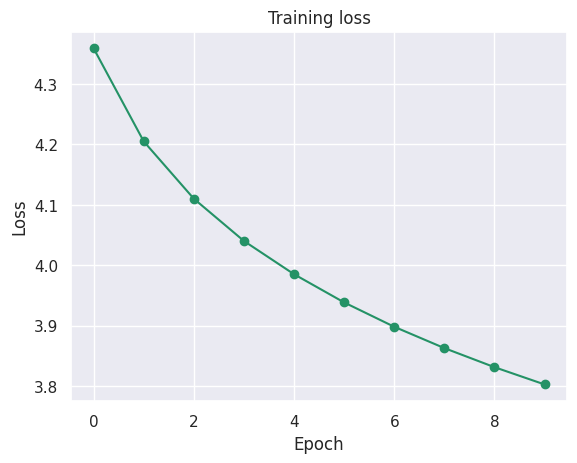

In [43]:
import matplotlib.pyplot as plt

plt.plot(losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.grid(True)
plt.show()


In [75]:
text = "I feel myself"
words = text.split(" ")
print(words[1])



feel


In [76]:
for word in words:
    print(f"{word}:{word2ind[word]}")

I:4608
feel:339
myself:4581


In [79]:
def encode_words(text, word2ind):
    words = text.split(" ")  # разбиваем по пробелам
    return [word2ind[w] for w in words if w in word2ind]

def decode_words(indices, ind2word):
    return ' '.join([ind2word[i] for i in indices])



In [81]:
test = "I feel"
ids = encode_words(test, word2ind)
print(ids)
print(decode(ids, ind2word))


[4608, 339]
I feel


In [86]:
import torch

def generate_text_gru(model, start_text, word2ind, ind2word, max_new_words=20, device='cuda'):
    model.eval()  
    words = start_text.split()
    input_ids = torch.tensor([encode_words(start_text, word2ind)], device=device)  

    generated = words.copy()

    for _ in range(max_new_words):
        with torch.no_grad():
            
            logits = model(input_ids)
            
            
            next_token_logits = logits[0, -1, :]
            
            
            probs = torch.softmax(next_token_logits, dim=-1)
            
        
            next_id = torch.argmax(probs).item()
            
            
            generated.append(ind2word[next_id])
            
            
            input_ids = torch.tensor([[next_id]], device=device)

    return ' '.join(generated)

   

In [87]:
start_text = "I feel"
output_text = generate_text_gru(model, start_text, word2ind, ind2word, max_new_words=20, device='cuda')
print(output_text)


I feel ashamed that fu <eos> Rice score Fiction relaxed wax museum abandon proceedings bores spoilers pictured Spinal Tap fatale average nation
